# LSTM & GRU Models on Fashion MNIST Dataset

In [2]:
%load_ext autoreload
%autoreload 2

# Reset all variables and import required libraries again
#%reset -f
#import utilities; import importlib; importlib.reload(utilities); from utilities import *

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import timeit
import seaborn as sns
import pickle
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torchvision.utils import make_grid
from PIL import Image
import glob
import os
from tqdm import tqdm

import utilities as utils
import models

utils.initialize_notebook()

utils.set_random_seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Library Versions:
- PyTorch: 1.11.0.post202
- Optuna: 2.10.0
- Numpy: 1.22.4
- Matplotlib: 3.5.2
- Seaborn: 0.11.2
- PIL: 9.1.1

More Information:
- torch.cuda.is_available() -> True
- plt.style.use() <- 'seaborn'


In [3]:
BATCH_SIZE = 128
NUM_EPOCHS = 25

## Loading the Dataset

Dataset (Train+Val) Size: 60000
Test Dataset Size: 10000


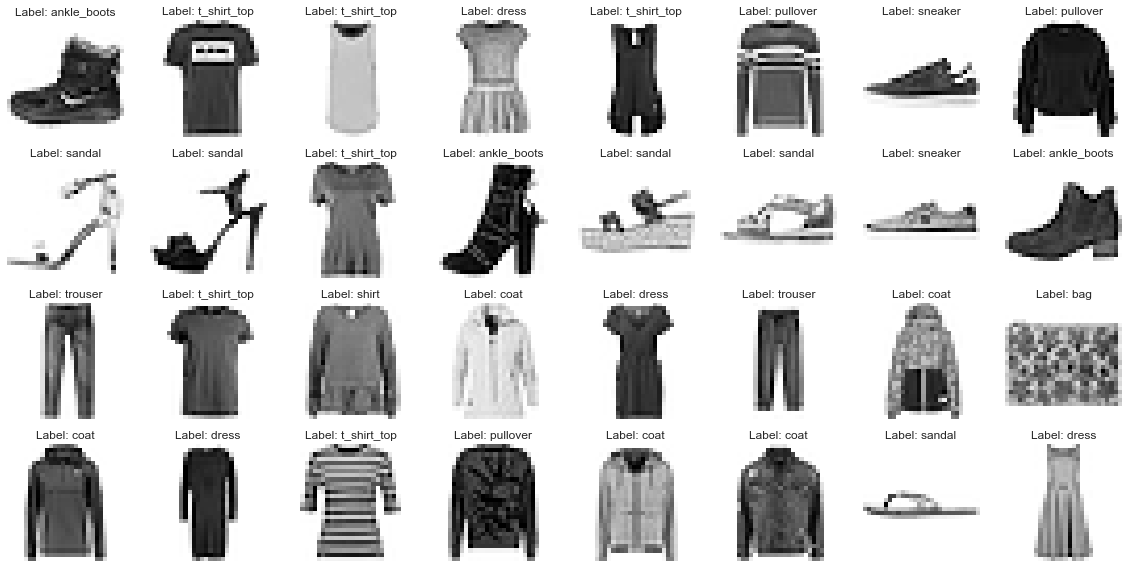

In [4]:
dataset = dsets.FashionMNIST(root="data/", train=True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.FashionMNIST(root="data/", train=False, transform=transforms.ToTensor(), download=True)

print("Dataset (Train+Val) Size:", len(dataset))
print("Test Dataset Size:", len(test_dataset))

dataset_labels = ['t_shirt_top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']
utils.show_grid(dataset, label_map=dataset_labels)

## Dataloader

In [5]:
batch_size=BATCH_SIZE

# We use about 20% of the dataset for validation.
val_size = int(len(dataset) * 0.20)
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print("Data sizes: \nTrain data size = {} \nValidation data size = {} \nTest data size = {} \nSingle Sample Shape: {}\n".format(len(train_dataset),len(val_dataset), len(test_dataset), train_dataset[0][0].size()))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size)

print("Total number of batches in one epoch (Train):", len(train_loader))
print("Total number of batches in one epoch (Validation):", len(val_loader))
print("Total number of batches in one epoch (Test):", len(test_loader))

Data sizes: 
Train data size = 48000 
Validation data size = 12000 
Test data size = 10000 
Single Sample Shape: torch.Size([1, 28, 28])

Total number of batches in one epoch (Train): 375
Total number of batches in one epoch (Validation): 94
Total number of batches in one epoch (Test): 79


images.shape: torch.Size([128, 1, 28, 28])
labels.shape: torch.Size([128])


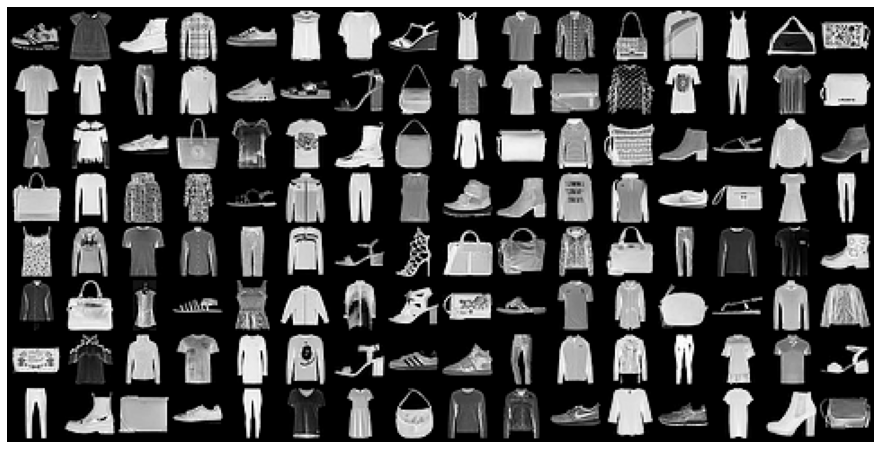

In [6]:
#Visualization of dataset in batches
for index, (images, labels) in enumerate(train_loader):
    print('images.shape:', images.shape)
    print('labels.shape:', labels.shape)
    plt.figure(figsize=(20,8))
    plt.axis('off')
    _=plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    if index+1 == 1:  #number of batches to visualize
        break

In [7]:
!nvidia-smi

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is : {device}")

Thu Jul 21 20:32:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.05    Driver Version: 510.73.05    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| N/A   52C    P8    20W /  N/A |    355MiB / 16384MiB |     34%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## PyTorch LSTM model (using nn.LSTM)

In [8]:
num_epochs = NUM_EPOCHS

model = models.LSTM_PyTorch_Model(input_dim=28, 
                           embed_dim=64, 
                           hidden_dim=128, 
                           out_dim=10, 
                           num_layers=2,
                           dropout=0.0,
                           hc_mode="zero_learned"
                          ).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

train_loss, val_loss, loss_iters, valid_acc= utils.train_model(model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, device=device)

Epoch 25/25 Train loss: 0.14053 Valid loss: 0.26454 Accuracy: 90.875%: 100%|█| 2


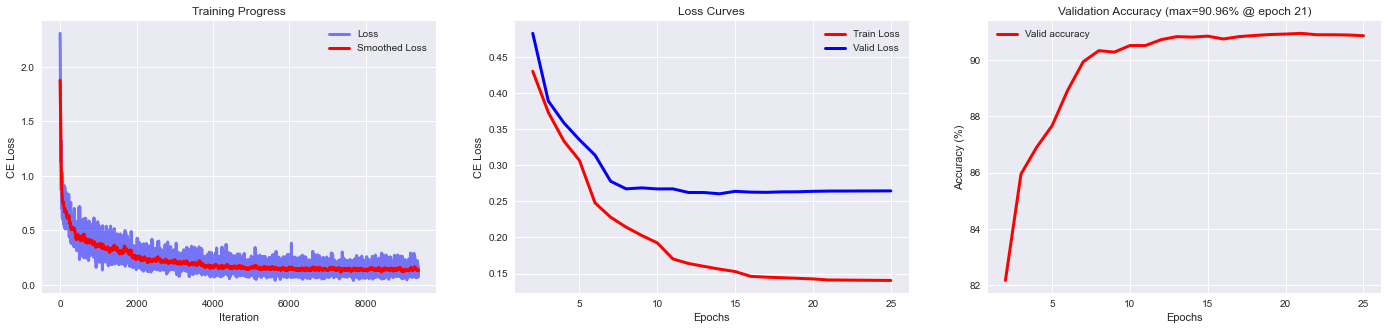

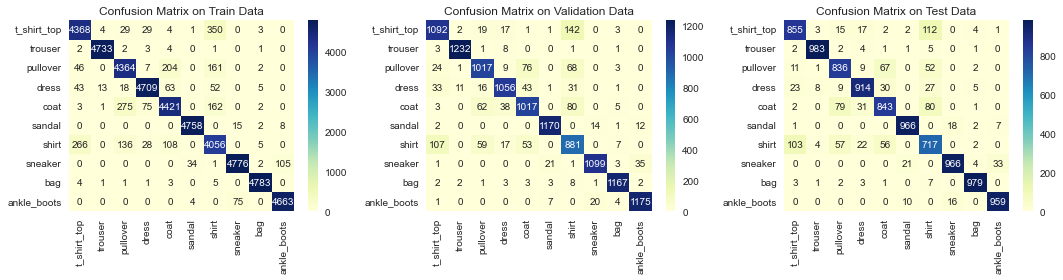

In [13]:
utils.plot_loss_train_val(loss_iters, train_loss, val_loss, valid_acc)
utils.confusion_matrix_3(model, train_loader, val_loader, test_loader, dataset_labels)

## My LSTM

In [17]:
# testing
m = models.MyLSTMCell(input_size=3, hidden_size=4).to(device)
c = torch.rand((2,4)).to(device)
h = torch.rand((2,4)).to(device)
x = torch.zeros((2,3)).to(device)
c_, h_ = m.forward(x, (h,c))
print(c_.shape, h_.shape)

torch.Size([2, 4]) torch.Size([2, 4])


In [18]:
# testing
m = models.MyLSTM(input_size=3, hidden_size=4, num_layers=2, bias=True, batch_first=True, dropout=0).to(device)
c = torch.rand((2,4)).to(device)
h = torch.rand((2,4)).to(device)
x = torch.zeros((2, 5, 3)).to(device)
output, (c_, h_) = m.forward(x, (h,c))
print(output.shape, c_.shape, h_.shape)

torch.Size([2, 5, 4]) torch.Size([2, 2, 4]) torch.Size([2, 2, 4])


In [21]:
num_epochs = NUM_EPOCHS

model = models.LSTM_PyTorch_Model(input_dim=28, 
                           embed_dim=64, 
                           hidden_dim=128, 
                           out_dim=10, 
                           num_layers=3,
                           dropout=0.0,
                           hc_mode="zero_init",
                           rnn_class=models.MyLSTM
                          ).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

train_loss, val_loss, loss_iters, valid_acc= utils.train_model(model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, device=device)

Epoch 25/25 Train loss: 0.1276 Valid loss: 0.27499 Accuracy: 90.68333333333334%:


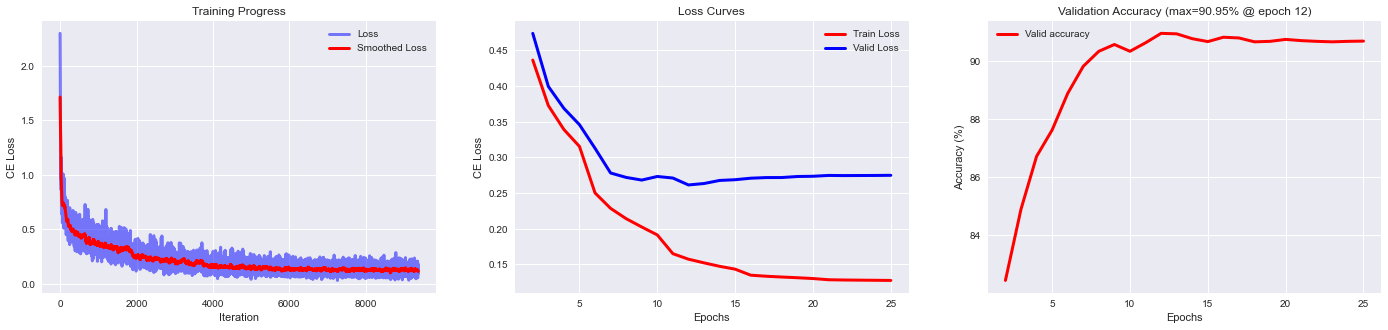

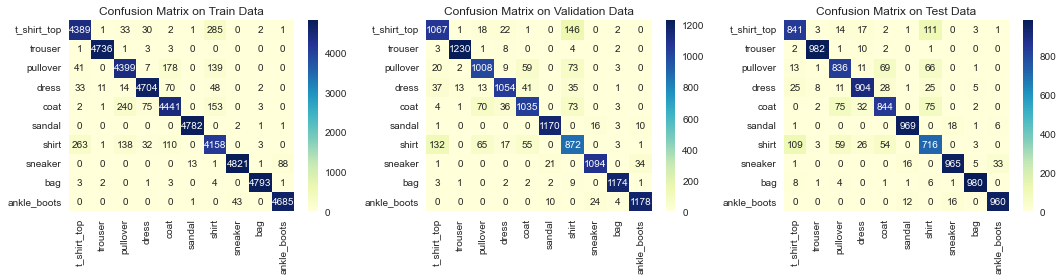

In [24]:
utils.plot_loss_train_val(loss_iters, train_loss, val_loss, valid_acc)
utils.confusion_matrix_3(model, train_loader, val_loader, test_loader, dataset_labels)

## MNIST GRU code using my GRU layer

In [25]:
# testing
gru = models.OurGRUCell(10, 24, device=device)
x = torch.rand((5,10))
h = torch.rand((5,24))
gru(x,h)

tensor([[-0.1894,  0.3374,  0.6183, -0.0224,  0.3184,  0.2252,  0.1305,  0.6139,
         -0.1288,  0.0382,  0.2353,  0.1547,  0.1198,  0.4166,  0.4687, -0.1896,
          0.5017,  0.4057,  0.1718,  0.0511,  0.1908,  0.5703,  0.2238,  0.5175],
        [ 0.1548,  0.5616,  0.3223,  0.2074,  0.2266,  0.0335,  0.0842,  0.2532,
         -0.0178, -0.0388,  0.3480,  0.2109,  0.0346,  0.2326,  0.1529,  0.2363,
          0.1990,  0.5544,  0.4135,  0.4786, -0.1000,  0.3070,  0.0553,  0.4837],
        [ 0.2940,  0.2068,  0.4202,  0.2141,  0.0769,  0.2593, -0.0617,  0.3740,
         -0.0454,  0.1420,  0.0747,  0.0096,  0.4359,  0.6197,  0.4482, -0.0180,
          0.2545,  0.1283,  0.0040,  0.2558, -0.0572,  0.5127,  0.0045,  0.5221],
        [-0.0971,  0.4681,  0.0558,  0.0696,  0.4303,  0.4425,  0.1229,  0.4584,
         -0.1439, -0.2902,  0.2846,  0.2534,  0.3757,  0.3407,  0.2095, -0.1391,
          0.0213,  0.2174,  0.2645,  0.1869,  0.3181,  0.5953,  0.1198,  0.3239],
        [ 0.0099,  0.638

In [26]:
# testing
m = models.OurGRU(input_size=3, hidden_size=4, num_layers=3, bias=True, batch_first=True, dropout=0).to(device)
h = torch.rand((3, 2, 4)).to(device)  # (num_layers, N=batch_size, H_out=hidden_size)
x = torch.zeros((2, 5, 3)).to(device)  # (N=batch_size, L=seq_len, H_in=input_size)
output, h_ = m.forward(x, h) # output.shape=((N, L, H_out=hidden_size) h_.shape=(num_layers, N=batch_size, H_out=hidden_size)
print(output.shape, h_.shape)             

torch.Size([2, 5, 4]) torch.Size([3, 2, 4])


In [28]:
num_epochs = NUM_EPOCHS

model = models.GRU_PyTorch_Model(input_dim=28, 
                           embed_dim=64, 
                           hidden_dim=128, 
                           out_dim=10, 
                           num_layers=2,
                           dropout=0.0,
                           hc_mode="zero_init",
                           rnn_class=models.OurGRU
                          ).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

train_loss, val_loss, loss_iters, valid_acc= utils.train_model(model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, device=device)

Epoch 25/25 Train loss: 0.10744 Valid loss: 0.25904 Accuracy: 91.27499999999999%


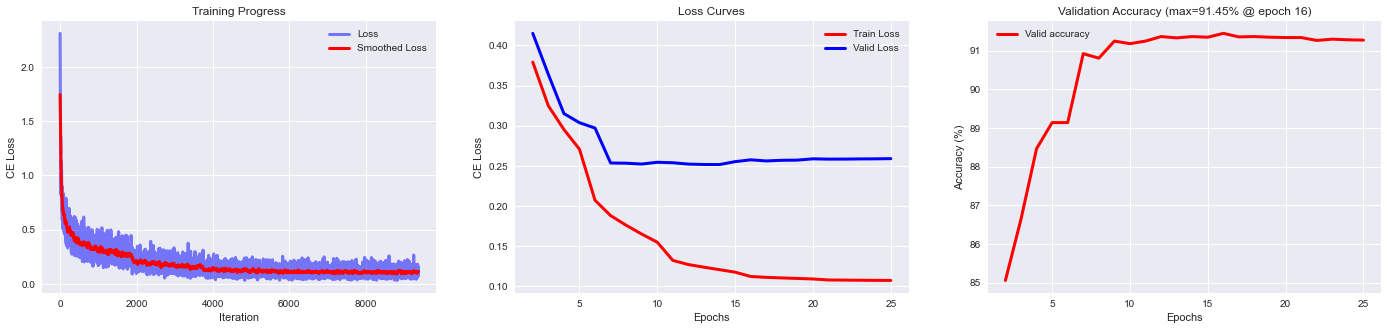

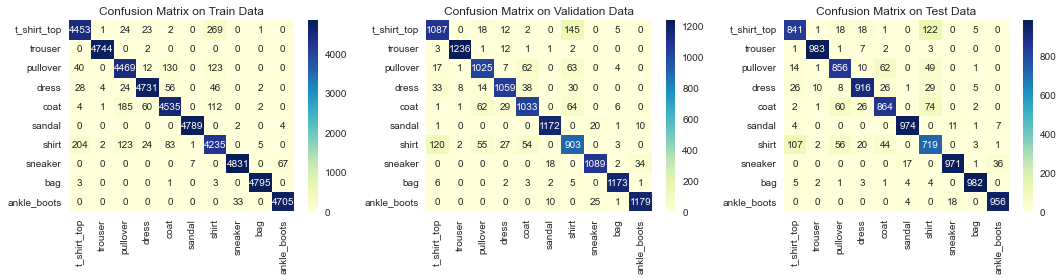

In [29]:
utils.plot_loss_train_val(loss_iters, train_loss, val_loss, valid_acc)
utils.confusion_matrix_3(model, train_loader, val_loader, test_loader, dataset_labels)

## Tuning the LSTM model with Optuna

In [32]:
import optuna

num_epochs = NUM_EPOCHS

def objective(trial):
    embed_dim = trial.suggest_int("embed_dim", 14, 128)
    hidden_dim = trial.suggest_int("hidden_dim", 28, 128)
    num_layers = trial.suggest_int("num_layers", 1, 4)
    if num_layers > 1:
        dropout = trial.suggest_float("dropout", 0.0, 0.5)
    else:
        dropout = trial.suggest_float("dropout", 0.0, 0.0)
    hc_mode = trial.suggest_categorical("hc_mode", ["zero_learned", "random_learned", "zero_init", "random_init"])
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    
    model = models.LSTM_PyTorch_Model(input_dim=28, 
                               embed_dim=embed_dim, 
                               hidden_dim=hidden_dim, 
                               out_dim=10, 
                               num_layers=num_layers,
                               dropout=dropout,
                               hc_mode=hc_mode
                              ).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

    train_loss, val_loss, loss_iters, valid_acc = utils.train_model(model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, device=device)
    
    utils.save_model(model, optimizer, num_epochs, [train_loss, val_loss, loss_iters, valid_acc])
    
    return val_loss[-1]

study = optuna.create_study()
study.optimize(objective, n_trials=50)
study.best_params

[I 2022-07-22 02:40:29,006] A new study created in memory with name: no-name-9b966ea1-c566-496c-83e1-ddd6419275bf
Epoch 25/25 Train loss: 1.29487 Valid loss: 1.29883 Accuracy: 61.56666666666667%
[I 2022-07-22 02:42:50,853] Trial 0 finished with value: 1.298832175579477 and parameters: {'embed_dim': 105, 'hidden_dim': 39, 'num_layers': 1, 'dropout': 0.0, 'hc_mode': 'zero_init', 'lr': 2.1853055256026848e-05}. Best is trial 0 with value: 1.298832175579477.
Epoch 25/25 Train loss: 0.35483 Valid loss: 0.37894 Accuracy: 86.225%: 100%|█| 2
[I 2022-07-22 02:45:17,501] Trial 1 finished with value: 0.37893768193873956 and parameters: {'embed_dim': 101, 'hidden_dim': 109, 'num_layers': 1, 'dropout': 0.0, 'hc_mode': 'random_learned', 'lr': 0.00027858357839509815}. Best is trial 1 with value: 0.37893768193873956.
Epoch 25/25 Train loss: 0.58885 Valid loss: 0.59193 Accuracy: 78.65833333333333%
[I 2022-07-22 02:48:01,618] Trial 2 finished with value: 0.5919252310661559 and parameters: {'embed_dim': 2

Epoch 25/25 Train loss: 0.23486 Valid loss: 0.29217 Accuracy: 89.53333333333333%
[I 2022-07-22 03:51:00,472] Trial 22 finished with value: 0.2921679148331602 and parameters: {'embed_dim': 93, 'hidden_dim': 116, 'num_layers': 4, 'dropout': 0.2798288827978533, 'hc_mode': 'random_init', 'lr': 0.0033878543463935927}. Best is trial 16 with value: 0.27089320139047945.
Epoch 25/25 Train loss: 0.24719 Valid loss: 0.30605 Accuracy: 89.16666666666667%
[I 2022-07-22 03:54:37,621] Trial 23 finished with value: 0.30604587939191374 and parameters: {'embed_dim': 71, 'hidden_dim': 106, 'num_layers': 3, 'dropout': 0.22602905178598162, 'hc_mode': 'random_init', 'lr': 0.008344209773242338}. Best is trial 16 with value: 0.27089320139047945.
Epoch 25/25 Train loss: 0.26052 Valid loss: 0.29661 Accuracy: 89.48333333333333%
[I 2022-07-22 03:57:52,263] Trial 24 finished with value: 0.29660639071718176 and parameters: {'embed_dim': 72, 'hidden_dim': 84, 'num_layers': 3, 'dropout': 0.3614879712322083, 'hc_mode':

Epoch 25/25 Train loss: 0.18176 Valid loss: 0.26816 Accuracy: 90.26666666666667%
[I 2022-07-22 04:56:38,972] Trial 44 finished with value: 0.26816393355739876 and parameters: {'embed_dim': 114, 'hidden_dim': 111, 'num_layers': 2, 'dropout': 0.05710618251377747, 'hc_mode': 'zero_init', 'lr': 0.001792555063471165}. Best is trial 35 with value: 0.26214391777807095.
Epoch 25/25 Train loss: 0.3417 Valid loss: 0.37003 Accuracy: 86.61666666666666%:
[I 2022-07-22 04:59:15,583] Trial 45 finished with value: 0.3700313197171434 and parameters: {'embed_dim': 128, 'hidden_dim': 123, 'num_layers': 1, 'dropout': 0.0, 'hc_mode': 'zero_learned', 'lr': 0.00025548842291249404}. Best is trial 35 with value: 0.26214391777807095.
Epoch 25/25 Train loss: 0.14559 Valid loss: 0.27694 Accuracy: 90.45833333333333%
[I 2022-07-22 05:02:11,433] Trial 46 finished with value: 0.2769421209046181 and parameters: {'embed_dim': 17, 'hidden_dim': 120, 'num_layers': 2, 'dropout': 0.171225763143392, 'hc_mode': 'zero_learned

{'embed_dim': 98,
 'hidden_dim': 122,
 'num_layers': 2,
 'dropout': 0.14197388961947266,
 'hc_mode': 'zero_learned',
 'lr': 0.004472322469099638}